In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys

In [2]:
sys.path.append('/home/local/WIN/msang2/mankun/dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
from Simulations.odeSolver.Nonly import rxnNetwork, labels
from Simulations.odeSolver.main import main as numericSolver
# for generating parameters
from GenerateParameters import GenParameters

In [3]:
def setSpineWidth(ax, spineLineWidth):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(spineLineWidth)
def setTickParams(majorSize, majorWidth, minorSize, minorWidth):
    # Set tick length and width for major ticks
    plt.rcParams['xtick.major.size'] = majorSize  # Length of major ticks in points
    plt.rcParams['xtick.major.width'] = majorWidth   # Width of major ticks in points
    plt.rcParams['ytick.major.size'] = majorSize
    plt.rcParams['ytick.major.width'] = majorWidth

    # Set tick length and width for minor ticks
    plt.rcParams['xtick.minor.size'] = minorSize    # Length of minor ticks in points
    plt.rcParams['xtick.minor.width'] = minorWidth   # Width of minor ticks in points
    plt.rcParams['ytick.minor.size'] = minorSize
    plt.rcParams['ytick.minor.width'] = minorWidth

# mean residence time phase diagram

In [4]:
def criticalRate_DNAclusTarg(parm):
    kbPS = parm['kbPS'].to_numpy()
    kbPN = parm['kbPN'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    chiS = parm['KPS'].to_numpy()*parm['CS0'].to_numpy()
    KPSC0chiS = parm['KPS'].to_numpy()*0.6022*chiS
    gamma = parm['gamma'].to_numpy()
    chiDNA = chiN + chiS + gamma*chiS*chiN
    onRate = (kbPS*chiS + kbPN*chiN)
    nu = (onRate*(2*gamma*chiN*chiS + gamma*chiN**2 + 2*(gamma*chiN)**2*chiS))
    nu_add = onRate*KPSC0chiS*(1+chiN*gamma)**2
    return (nu+nu_add)/chiDNA**2

def criticalRate_DNAtarg(parm):
    kbPS = parm['kbPS'].to_numpy()
    kbPN = parm['kbPN'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    chiS = parm['KPS'].to_numpy()*parm['CS0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    chiDNA = chiN + chiS + gamma*chiS*chiN
    onRate = (kbPS*chiS + kbPN*chiN)
    nu = (onRate*(2*gamma*chiN*chiS + gamma*chiN**2 + 2*(gamma*chiN)**2*chiS))
    return nu/chiDNA**2

def criticalRate_DNA(parm):
    kbPN = parm['kbPN'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    return gamma*chiN*kbPN

In [37]:
parms = GenParameters(
    numTargets=2, KPS=lambda KPN: 1000, kaPS=1000, kaPN=200,
    KPN=[20], NP0=[0.1], area3Dto1D=np.logspace(0,3,100), 
    KPP=[1e3], kbPP_fixed=5,
)


In [53]:
# parms['kaPP'].unique()*0.6022 / 1e6
# parms['kbPP'].unique()
# parms['KPP'].unique()*0.6022
# parms['CP0'].unique() / 0.6022 * 1e6
# parms['kaPN'].unique()*0.6022
# parms['kbPN'].unique()
# parms['KPN'].unique()*0.6022
# parms['CN0'].unique() / 0.6022 * 1e3
# parms['kaPS'].unique()*0.6022
# parms['kbPS'].unique()
# parms['KPS'].unique()*0.6022
# parms['CS0'].unique() / 0.6022 * 1e3
# parms['gamma'].unique()

array([0.15815027])

In [62]:
def plotOneFigure(ymax, label, color, hatch):
    
    # ax.spines['top'].set_linewidth(0)
    ymin = 0.9e-2
    gammaChiNkoff = parms['gamma'].to_numpy()*parms['CN0'].to_numpy()*parms['KPN'].to_numpy()

    plt.plot(gammaChiNkoff, ymax, color=color)
    
    if hatch.strip()=='':
        plt.fill_between(
            gammaChiNkoff, ymin, ymax, label=label,
            facecolor=color, alpha=0.5,
        )
    else:
        plt.fill_between(
            gammaChiNkoff, ymin, ymax, label=label,
            facecolor='none', edgecolor=color, hatch=hatch, alpha=0.5,
        )

    plt.xlim([min(gammaChiNkoff), max(gammaChiNkoff)])
    plt.ylim([ymin, 5e3])

#     plt.xticks([1e0,1e1,1e2],['','',''])

    plt.loglog()

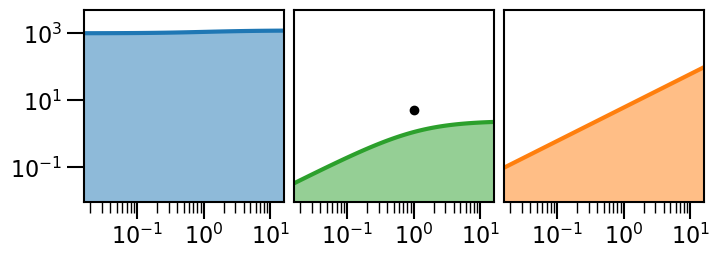

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(8,2.5), constrained_layout=False)
plt.subplots_adjust(wspace=0.05)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 16
setTickParams(12, 1.5, 8, 1)

spineWidth = 1.5
ax = plt.subplot(131)
setSpineWidth(ax, spineWidth)
plotOneFigure(criticalRate_DNAclusTarg(parms), 'DNA+clusTarg', 'tab:blue', '')
ax = plt.subplot(133)
setSpineWidth(ax, spineWidth)
plotOneFigure(criticalRate_DNA(parms), 'DNA', 'tab:orange', '')
plt.yticks([])
ax = plt.subplot(132)
plt.scatter([1], parms['kbPP'].unique(), color='black')
setSpineWidth(ax, spineWidth)
plotOneFigure(criticalRate_DNAtarg(parms), 'DNA+targ', 'tab:green', '')
plt.yticks([])
plt.show()

# occupancy phase diagram

In [64]:
from scipy.optimize import root_scalar

In [24]:
def findCriticalXPS(parm):
    '''chiS -> (-chiN + chiN G)/(1 + chiN G)^2'''
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    return chiN*(gamma-1)/(1+gamma*chiN)**2

def solveGamma(parm):
    '''chiS -> (-chiN + chiN G)/(1 + chiN G)^2'''
    chiN = np.unique(parm['KPN']*parm['CN0'])
    chiS = np.unique(parms['CN0']*parms['KPN'])
    ftosolve = lambda gamma: chiN*(gamma-1)/(1+gamma*chiN)**2 - chiS
    return root_scalar(ftosolve, x0=1), root_scalar(ftosolve, x0=10)

In [27]:
chiS_select = parms['KPS'].unique() * parms['CS0'].unique()

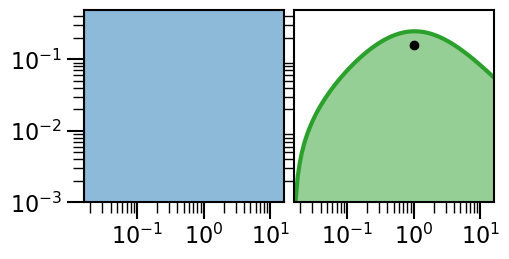

In [57]:
# set figure parameters
fig, axes = plt.subplots(1, 3, figsize=(8,2.5), constrained_layout=False)
plt.subplots_adjust(wspace=0.05)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 16
setTickParams(12, 1.5, 8, 1)
plt.rcParams['ytick.minor.size'] = 0
spineWidth = 1.5
# prepare data
gammaChiN = parms['gamma'].to_numpy()*parms['CN0'].to_numpy()*parms['KPN'].to_numpy()
chiN = np.unique(parms['CN0']*parms['KPN'])
chiS = np.unique(parms['CN0']*parms['KPN'])
xmin = min(gammaChiN)
xmax = max(gammaChiN)
chiCritic = findCriticalXPS(parms)
ymin = 1e-3
ymax = max(chiCritic)*2

# plot
ax = plt.subplot(131)
setSpineWidth(ax, spineWidth)
plt.fill_between(
    gammaChiN, ymin, ymax, label='DNA+clusTarg', color='tab:blue', alpha=0.5
)
plt.loglog()
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

ax = plt.subplot(132)
setSpineWidth(ax, spineWidth)
plt.plot(gammaChiN, chiCritic, color='tab:green')
plt.fill_between(
    gammaChiN, ymin, chiCritic, label='DNA+targ', color='tab:green', alpha=0.5
)
plt.scatter([1], chiS_select, color='black')
plt.loglog()
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.yticks([])

ax = plt.subplot(133)
ax.remove()


plt.show()

# protein bound ratio

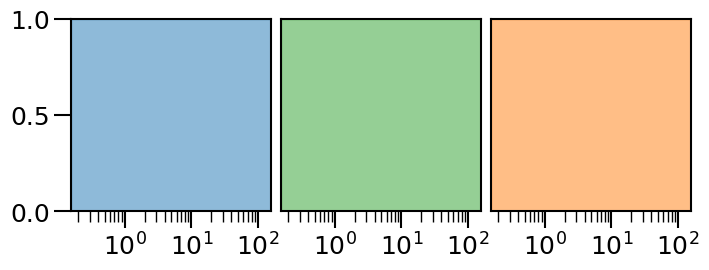

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(8,2.5), constrained_layout=False)
plt.subplots_adjust(wspace=0.05)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 18
setTickParams(12, 1.5, 8, 1)
spineWidth = 1.5

gammaChiN = parms['gamma'].to_numpy()*parms['CN0'].to_numpy()*parms['KPN'].to_numpy()

ax = plt.subplot(131)
setSpineWidth(ax, spineWidth)
plt.fill_between(
    gammaChiN, 0, 1, label='DNA+clusTarg', color='tab:blue', alpha=0.5
)
plt.semilogx()
plt.xlim([min(gammaChiN),max(gammaChiN)])
plt.ylim([0,1])

ax = plt.subplot(133)
setSpineWidth(ax, spineWidth)
plt.fill_between(
    gammaChiN, 0, 1, label='DNA', color='tab:orange', alpha=0.5,
)
plt.semilogx()
plt.yticks([])
plt.xlim([min(gammaChiN),max(gammaChiN)])
plt.ylim([0,1])

ax = plt.subplot(132)
setSpineWidth(ax, spineWidth)
plt.fill_between(
    gammaChiN, 0, 1, label='DNA+targ', color='tab:green', alpha=0.5
)
plt.semilogx()
plt.yticks([])
plt.xlim([min(gammaChiN),max(gammaChiN)])
plt.ylim([0,1])
plt.show()

# legends

([], [])

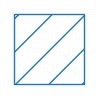

In [206]:
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(111)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0)  # change width

plt.fill_between(
    gammaChiN, 0, 1, label='DNA+clusTarg',
    facecolor='none', edgecolor='tab:blue', hatch='/', alpha=1.0
)

plt.xticks([])
plt.yticks([])




([], [])

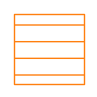

In [207]:
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(111)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0)  # change width

plt.fill_between(
    gammaChiN, 0, 1, label='DNA', 
    facecolor='none', edgecolor='tab:orange', hatch='-', alpha=1.0,
)

plt.xticks([])
plt.yticks([])




([], [])

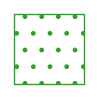

In [208]:
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(111)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0)  # change width

plt.fill_between(
    gammaChiN, 0, 1, label='DNA+targ',
    facecolor='none', edgecolor='tab:green', hatch='.', alpha=1.0
)

plt.xticks([])
plt.yticks([])


([], [])

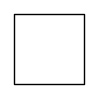

In [209]:
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(111)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0)  # change width

plt.fill_between(
    gammaChiN, 0, 1, label='DNA+targ',
    facecolor='none', 
)

plt.xticks([])
plt.yticks([])
